In [1]:
import keras
import pandas as pd
import numpy as np

from augmenter import Augmenter
from image_generator import deepaugment_generator

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
TRAIN_SIZE = 10000
BATCH_SIZE = 64

In [6]:
from build_features import DataOp

data, inp_shape = DataOp.load("cifar10", TRAIN_SIZE)
data = DataOp.preprocess(data)
# ['brighten', 0.107, 'translate-x', 0.025, 'fog', 0.035, 1.0]
# ['sharpen', 0.105, 'coarse-dropout', 0.604, 'translate-y', 0.836, 1.0]
policy = [
    {
        "aug1_type": "brighten",
        "aug1_magnitude": 0.107,
        "aug2_type": "translate-x",
        "aug2_magnitude": 0.025,
        "portion": 1.0,
    },
    {
        "aug1_type": "sharpen",
        "aug1_magnitude": 0.105,
        "aug2_type": "coarse-dropout",
        "aug2_magnitude": 0.604,
        "portion": 1.0,
    }
]

tested_generator = deepaugment_generator(
    data["X_train"], data["y_train"], 
    policy, batch_size=64, augment_chance=0.5)


In [7]:
ims = next(tested_generator)
ims[0].shape

(64, 32, 32, 3)

### Each set of consequtive 4 images should have either non-augmented or augmented by one of the policies

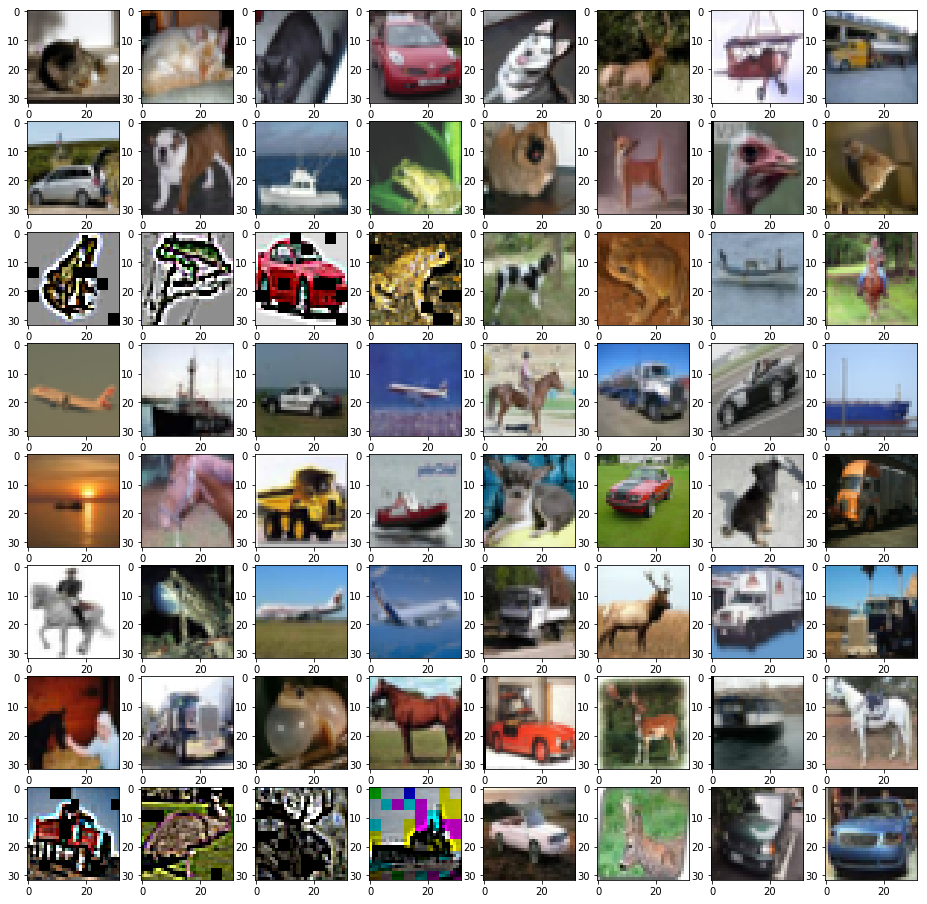

In [8]:
plt.figure(figsize=(16,16))
for i in range(1,65):
    plt.subplot(8,8,i)
    plt.imshow(ims[0][i-1])

In [9]:
import logging
from childcnn import ChildCNN

X_val = data["X_val_seed"][:1000]
y_val = data["y_val_seed"][:1000]

# Train child model with augmented data (using generator in test)

In [10]:
child_model = ChildCNN(
    model_name="basiccnn", input_shape=inp_shape, batch_size=64, num_classes=10,
    pre_augmentation_weights_path="initial_model_weights.h5", logging=logging
)

history_of_augmented_model = child_model.model.fit_generator(
    tested_generator,
    steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
    epochs=50,
    validation_data=(X_val, y_val)
)

del child_model

BasicCNN model built as child model.
 Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)      

Epoch 41/50
156/156 [==============================] - 23s 146ms/step - loss: 1.1097 - acc: 0.6124 - val_loss: 1.1228 - val_acc: 0.6000
Epoch 42/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0755 - acc: 0.6192 - val_loss: 1.2061 - val_acc: 0.6050
Epoch 43/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0813 - acc: 0.6272 - val_loss: 0.9284 - val_acc: 0.6690
Epoch 44/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0820 - acc: 0.6296 - val_loss: 0.9702 - val_acc: 0.6480
Epoch 45/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0897 - acc: 0.6295 - val_loss: 1.1016 - val_acc: 0.6260
Epoch 46/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0918 - acc: 0.6304 - val_loss: 1.0823 - val_acc: 0.6240
Epoch 47/50
156/156 [==============================] - 23s 146ms/step - loss: 1.0760 - acc: 0.6313 - val_loss: 0.9952 - val_acc: 0.6360
Epoch 48/50
156/156 [===========================

# Train child model with non-augmented data

In [11]:
child_model = ChildCNN(
    model_name="basiccnn", input_shape=inp_shape, batch_size=64, num_classes=10,
    pre_augmentation_weights_path="initial_model_weights.h5", logging=logging
)

history_of_non_augmented_model = child_model.model.fit(
    x=data["X_train"],
    y=data["y_train"],
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=(X_val, y_val)
)

del child_model

BasicCNN model built as child model.
 Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)      

Epoch 40/50
10000/10000 [==============================] - 23s 2ms/step - loss: 0.9274 - acc: 0.6732 - val_loss: 1.0784 - val_acc: 0.6400
Epoch 41/50
10000/10000 [==============================] - 24s 2ms/step - loss: 0.9204 - acc: 0.6826 - val_loss: 1.0830 - val_acc: 0.6160
Epoch 42/50
10000/10000 [==============================] - 24s 2ms/step - loss: 0.9135 - acc: 0.6799 - val_loss: 1.0016 - val_acc: 0.6410
Epoch 43/50
10000/10000 [==============================] - 23s 2ms/step - loss: 0.9070 - acc: 0.6872 - val_loss: 1.1465 - val_acc: 0.6240
Epoch 44/50
10000/10000 [==============================] - 23s 2ms/step - loss: 0.9228 - acc: 0.6778 - val_loss: 1.0868 - val_acc: 0.6400
Epoch 45/50
10000/10000 [==============================] - 23s 2ms/step - loss: 0.9076 - acc: 0.6825 - val_loss: 1.1492 - val_acc: 0.6390
Epoch 46/50
10000/10000 [==============================] - 24s 2ms/step - loss: 0.9047 - acc: 0.6896 - val_loss: 1.0278 - val_acc: 0.6690
Epoch 47/50
10000/10000 [=========

In [12]:
aug_hist_df = pd.DataFrame(history_of_augmented_model.history)
nonaug_hist_df = pd.DataFrame(history_of_nonaugmented_model.history)

aug_hist_df

NameError: name 'history_of_nonaugmented_model' is not defined

In [13]:
import pandas as pd

In [16]:
li = [
    ['gamma-contrast', 0.79, 'dropout', 0.23, 0.43, 5.2],
    ['gaussian-blur', 0.97, 'coarse-dropout', 0.17, 0.56, 4.8]
]

pd.DataFrame(li, columns=["aug-1_type","aug-1_magnitude","aug-2_type","aug2-magnitude","probability","expected-accuracy-boost"])

,aug-1_type,aug-1_magnitude,aug-2_type,aug2-magnitude,probability,expected-accuracy-boost
0,gamma-contrast,0.79,dropout,0.23,0.43,5.2
1,gaussian-blur,0.97,coarse-dropout,0.17,0.56,4.8
